In [1]:
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr

# results_folder = r'/scratch/gpfs/allenwu/analysis_results_Mar_2023_cluster'
# results_folder_swapped = r'/scratch/gpfs/allenwu/analysis_results_Mar_2023_cluster_swapped_delta_materials'

# returns original delta_materials data structure (used to generate MMA plots)
results_folder_bishop_change = r'/scratch/gpfs/allenwu/analysis_results_Mar_2023_cluster_3_bishop_change'

# return translated translated_delta_materials data structure (used to generate beta value results)
results_folder_all_translated = r'/scratch/gpfs/allenwu/analysis_results_Mar_2023_cluster_all_translated'

In [2]:
# aggregate data in order of job_idx (such that delta_materials and move_match line up)
job_indices_hm = defaultdict(list)
moves_per_run = 22000
n_total_runs = 300

for i in range(0, n_total_runs):
    start_idx = i * moves_per_run
    end_idx = ((i+1)*moves_per_run) - 1
    job_indices_hm[i] = [start_idx, end_idx]
    
# Iterate over the sorted hm and save the files
all_delta_materials = []
all_move_matches = []        
for job_idx, [start_idx, end_idx] in job_indices_hm.items():
    if job_idx == 0:
        continue
        
    delta_materials_file_name = f'job_{job_idx}_start_{start_idx}_end_{end_idx}_delta_materials.npy'
    move_match_file_name = f'job_{job_idx}_start_{start_idx}_end_{end_idx}_move_match.npy'

    delta_materials_path = os.path.join(results_folder_all_translated, delta_materials_file_name)
    # Load the delta_materials array from the file
    with open(delta_materials_path, 'rb') as f:
        delta_materials = np.load(f, allow_pickle=True)
        all_delta_materials.append(delta_materials)

    move_match_path = os.path.join(results_folder_all_translated, move_match_file_name)
    # Load the move_match array from the file
    with open(move_match_path, 'rb') as f:
        move_matches = np.load(f, allow_pickle=True)
        all_move_matches.append(move_matches)
        
print(len(all_delta_materials[0]))
print(len(all_move_matches[0]))
          
# Concatenate all delta_materials arrays into a single array
combined_delta_materials = np.concatenate(all_delta_materials)
print(combined_delta_materials.shape)   # should be (6M, 36) --> correct!
# print(combined_delta_materials)

# Concatenate all move_match arrays into a single array
combined_move_matches = np.concatenate(all_move_matches)
print(combined_move_matches.shape)   # should be (6M,) --> correct!
# print(combined_move_matches)

21434
21434
(6415507, 36)
(6415507,)


In [3]:
# logistic regression results are a little hard to interpret --> do this alternative construction (conditional means for each of 36 events on accuracy)
# we ultimately want a vector of length 36 (with conditional probs for each event) + accuracy prob if there was no event
conditional_totals = [[0, 0] for i in range(36)]   # (total_correct, total) for each event tracked
total_correct = 0
for i, events in enumerate(combined_delta_materials):
    if combined_move_matches[i] == 1:
        total_correct += 1
        
    # events vector is of length 36 too
    for j in range(len(events)):
        if events[j] == 1:
            conditional_totals[j][1] += 1
            
            if combined_move_matches[i] == 1:
                conditional_totals[j][0] += 1
            
conditional_accuracies = [round(conditional_totals[i][0] / conditional_totals[i][1], 3) for i in range(len(conditional_totals))]
# print("conditional accuracies of all 36 events:\n", conditional_accuracies)      

conditional_accuracies_table = [conditional_accuracies[i:i+6] for i in range(0, len(conditional_accuracies), 6)]
print("Conditional accuracies in a 6x6 table format:")
for row in conditional_accuracies_table:
    formatted_row = ["{:.3f}".format(prob) for prob in row]
    print(formatted_row)
    
unconditional_accuracy = round(total_correct / len(combined_move_matches), 3)
print("accuracy if no event considered:\n", unconditional_accuracy)

Conditional accuracies in a 6x6 table format:
['0.308', '0.548', '0.605', '0.681', '0.718', '0.737']
['0.378', '0.384', '0.417', '0.424', '0.443', '0.402']
['0.387', '0.363', '0.370', '0.358', '0.420', '0.396']
['0.385', '0.373', '0.377', '0.373', '0.403', '0.396']
['0.387', '0.375', '0.365', '0.362', '0.391', '0.385']
['0.386', '0.379', '0.363', '0.365', '0.390', '0.390']
accuracy if no event considered:
 0.384


In [3]:
# remove 0th, 6th, 12th, 18th, 24th, 30th columns (all cases where nothing is captured across 6 depths)
# only need to run once every time combined_delta_materials is constructed from scratch
combined_delta_materials = np.delete(combined_delta_materials, [0,6,12,18,24,30], axis=1)

In [4]:
import numpy as np
import statsmodels.api as sm

# Reshape combined_move_match to match the shape of translated_delta_materials
combined_move_matches = combined_move_matches.reshape(-1, 1)

# Add constant term for intercept
combined_delta_materials_with_const = sm.add_constant(combined_delta_materials)
combined_delta_materials_with_const = np.array(combined_delta_materials_with_const, dtype=float)

# Create and fit the logistic regression model
logit_model = sm.Logit(combined_move_matches, combined_delta_materials_with_const)
if combined_delta_materials_with_const.shape[1] > 1:
    logit_result = logit_model.fit()
else:
    logit_result = logit_model.fit()

# Retrieve the coefficients (beta weights) from the trained model
beta_weights = logit_result.params[1:]  # Exclude the intercept
intercept = logit_result.params[0]
print(logit_result.summary)

# Reshape beta_weights for interpretation
beta_weights = beta_weights.reshape(6, 5)

print("Beta Weights:")
print(beta_weights)
print("Intercept:", intercept)

# 3 trends here:
# 1.) when you gain pieces, gaining a higher valued piece makes you more accurate
# 2.) when you lose pieces, losing a higher valued piece makes you less accurate (people value bishops more than rooks when losing (or ppl are good at rook sacrifices), value bishops more than knights consistently)
# 3.) all these effects get smaller with increasing depths

# removing all cols where no capture occurs = more meaningful intercept --> more meaningful + and - values for other values too (if hurting or helping you make right move)

# relate results back to Huys paper
# problem: don't know what exact person's valuation function is relative to stockfish

# 3 plots tentatively (all, all + elos side by side, all + times side by side)
# one idea: x-axis = pawn,knight,bishop,rook,queen, y-axis=beta values (one colored line for each depth, solid line for active move/even rows, dotted line for opponent move/odd rows)

Optimization terminated successfully.
         Current function value: 0.620658
         Iterations 5
<bound method BinaryResults.summary of <statsmodels.discrete.discrete_model.LogitResults object at 0x150ea0f40730>>
Beta Weights:
[[ 1.08617869  1.6031123   1.8570304   2.11980647  2.55275271]
 [-0.24957114 -0.62466437 -0.84061586 -0.79495075 -1.4476983 ]
 [-0.03979496  0.20527145  0.23752524  0.41483596  0.61950636]
 [-0.04477432 -0.20793206 -0.27646568 -0.19426927 -0.41117905]
 [-0.04903066  0.02566418  0.02001122  0.06648945  0.14923421]
 [ 0.02177065 -0.10400401 -0.1322328  -0.03184203 -0.09974072]]
Intercept: -0.7407212098663659


In [5]:
print(logit_result.bse[1:].reshape(6,5))

[[0.00271484 0.00420623 0.00441695 0.00602367 0.00812352]
 [0.00309993 0.00481815 0.0049588  0.00636258 0.00821325]
 [0.00296222 0.00496087 0.0050071  0.00593159 0.00748548]
 [0.00303239 0.00501926 0.00528749 0.0064584  0.00806606]
 [0.00291027 0.00500331 0.00513449 0.00613821 0.00749428]
 [0.0028432  0.00464657 0.00498304 0.00599244 0.00698391]]


In [6]:
print(logit_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              6415507
Model:                          Logit   Df Residuals:                  6415476
Method:                           MLE   Df Model:                           30
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                 0.06784
Time:                        22:34:58   Log-Likelihood:            -3.9818e+06
converged:                       True   LL-Null:                   -4.2716e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7407      0.001   -595.045      0.000      -0.743      -0.738
x1             1.0862      0.003    400.090      0.000       1.081       1.091
x2             1.6031      0.004    381.128      0.0

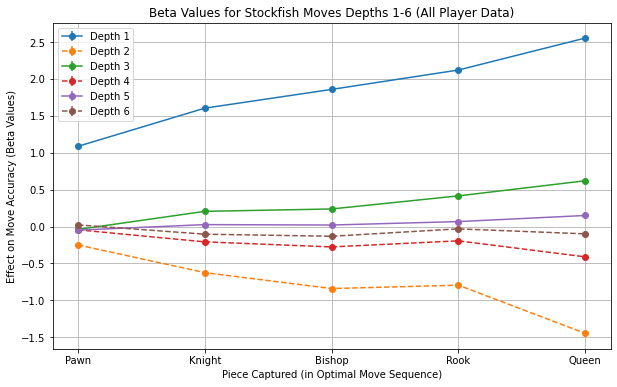

In [7]:
# create the line plot for all player data
# Depth labels
depth_labels = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6']

# Pieces labels
piece_labels = ['Pawn', 'Knight', 'Bishop', 'Rook', 'Queen']

# Adjust figure size
plt.figure(figsize=(10, 6))

# Plotting
for i in range(len(depth_labels)):
    if i % 2 == 0:
        plt.errorbar(piece_labels, beta_weights[i], yerr=logit_result.bse[1:].reshape(6,5)[i], marker='o', linestyle='-', label=depth_labels[i])
    else:
        plt.errorbar(piece_labels, beta_weights[i], yerr=logit_result.bse[1:].reshape(6,5)[i], marker='o', linestyle='--', label=depth_labels[i])

plt.xlabel('Piece Captured (in Optimal Move Sequence)')
plt.ylabel('Effect on Move Accuracy (Beta Values)')
plt.title('Beta Values for Stockfish Moves Depths 1-6 (All Player Data)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# to address "don't know what exact person's valuation function is relative to stockfish" in relation to Huys' paper
# only include moves where active player could gain large positive material exchange for d5+6 that makes up for previous exchanges
# makes our trees quite similar to huys trees (run regression for just d1-d4)
# would confidently see if people are missing big opportunities that occur at later depth by pruning at earlier depth
# NOTE: no 0th col from the original data structure since removed that col
# NOT USING NOW
material_hm = {0:1, 1:3, 2:3, 3:5, 4:9}
filtered_combined_delta_materials = []
filtered_combined_move_matches = []
for i, events in enumerate(combined_delta_materials):
    events = events.reshape(6,5)
    
    # for every move, calculate net exchange of d1-d4 moves
    full_exchange = 0
    for j, depth_exchange in enumerate(events):
        for k in range(len(depth_exchange)):
            if depth_exchange[k] == 1:
                if j % 2 == 0:
                    full_exchange += material_hm[k]
                else:
                    full_exchange -= material_hm[k]
                break
#     if prior_exchange >= 0:
#         continue
    
#     # calculate net exchange of d5-d6 moves
#     next_exchange = 0
#     for j, depth_exchange in enumerate(events[4:]):
#         for k in range(len(depth_exchange)):
#             if depth_exchange[k] == 1:
#                 if j % 2 == 0:
#                     next_exchange += material_hm[k]
#                 else:
#                     next_exchange -= material_hm[k]
#                 break
                
    # add row if next_exchange > abs(prior_exchange), where prior_exchange is negative
    if full_exchange >= 3:
        events = events.reshape(-1)
        filtered_combined_delta_materials.append(events)
        filtered_combined_move_matches.append(combined_move_matches[i])
        
print(len(filtered_combined_delta_materials), len(filtered_combined_delta_materials[0]))
print(len(filtered_combined_move_matches))

624425 30
624425


In [9]:
filtered_combined_delta_materials = np.array(filtered_combined_delta_materials)
filtered_combined_move_matches = np.array(filtered_combined_move_matches)
print("filtered delta materials shape:", filtered_combined_delta_materials.shape)
print("filtered move matches shape:", filtered_combined_move_matches.shape)

# only run regression on d1-d4 moves (only need to run once
filtered_combined_delta_materials_d1_d4 = np.delete(filtered_combined_delta_materials, range(20, 30), axis=1)
print(filtered_combined_delta_materials_d1_d4.shape)

filtered delta materials shape: (624425, 30)
filtered move matches shape: (624425, 1)
(624425, 20)


In [10]:
import numpy as np
import statsmodels.api as sm

# Reshape combined_move_match to match the shape of translated_delta_materials
filtered_combined_move_matches = filtered_combined_move_matches.reshape(-1, 1)

# Add constant term for intercept
filtered_combined_delta_materials_d1_d4_with_const = sm.add_constant(filtered_combined_delta_materials_d1_d4)
filtered_combined_delta_materials_d1_d4_with_const = np.array(filtered_combined_delta_materials_d1_d4_with_const, dtype=float)

# Create and fit the logistic regression model
filtered_logit_model = sm.Logit(filtered_combined_move_matches, filtered_combined_delta_materials_d1_d4_with_const)
filtered_logit_result = filtered_logit_model.fit()

# Retrieve the coefficients (beta weights) from the trained model
filtered_beta_weights = filtered_logit_result.params[1:]  # Exclude the intercept
filtered_intercept = filtered_logit_result.params[0]

# Reshape beta_weights for interpretation
filtered_beta_weights = filtered_beta_weights.reshape(4, 5)

print("Beta Weights:")
print(filtered_beta_weights)
print("Intercept:", filtered_intercept)

Optimization terminated successfully.
         Current function value: 0.568851
         Iterations 6
Beta Weights:
[[ 0.6120641   1.51596506  1.69087228  1.92487788  2.27509191]
 [-0.09571773 -0.46448558 -0.57013248 -0.53370449 -1.37836641]
 [-0.17219907 -0.10447095 -0.11244151  0.08420552  0.34723175]
 [ 0.0675823  -0.1153917  -0.15514969 -0.17619522 -0.37687041]]
Intercept: -0.4055123692090797


In [11]:
print(filtered_logit_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               624425
Model:                          Logit   Df Residuals:                   624404
Method:                           MLE   Df Model:                           20
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                  0.1059
Time:                        22:36:01   Log-Likelihood:            -3.5520e+05
converged:                       True   LL-Null:                   -3.9728e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4055      0.008    -53.835      0.000      -0.420      -0.391
x1             0.6121      0.011     55.109      0.000       0.590       0.634
x2             1.5160      0.009    162.783      0.0

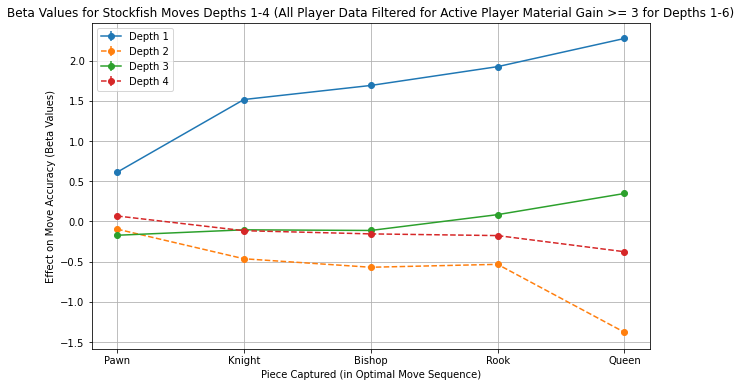

In [12]:
# create the line plot for all player data
# Depth labels
depth_labels = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4']

# Pieces labels
piece_labels = ['Pawn', 'Knight', 'Bishop', 'Rook', 'Queen']

# Adjust figure size
plt.figure(figsize=(10, 6))

# Plotting
for i in range(len(depth_labels)):
    if i % 2 == 0:
        plt.errorbar(piece_labels, filtered_beta_weights[i], yerr=filtered_logit_result.bse[1:].reshape(4,5)[i], marker='o', linestyle='-', label=depth_labels[i])
    else:
        plt.errorbar(piece_labels, filtered_beta_weights[i], yerr=filtered_logit_result.bse[1:].reshape(4,5)[i], marker='o', linestyle='--', label=depth_labels[i])

plt.xlabel('Piece Captured (in Optimal Move Sequence)')
plt.ylabel('Effect on Move Accuracy (Beta Values)')
plt.title('Beta Values for Stockfish Moves Depths 1-4 (All Player Data Filtered for Active Player Material Gain >= 3 for Depths 1-6)')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
def custom_sum(delta_materials_row):
    total = 0
    for val in delta_materials_row:
        if val == 4:
            total += 3
        else:
            total += val
    return total

def custom_max(delta_materials_row):
    max_val = max(delta_materials_row)
    return 3 if max_val == 4 else max_val

def custom_immediate_val_1(delta_materials_row):
    return 3 if delta_materials_row[0] == 4 else delta_materials_row[0]

def custom_immediate_val_2(delta_materials_row):
    return 3 if delta_materials_row[1] == 4 else delta_materials_row[1]

def custom_immediate_val_3(delta_materials_row):
    return 3 if delta_materials_row[2] == 4 else delta_materials_row[2]

In [53]:
# now that we've combined all delta_materials.npy and move_match.npy files into a two lists,
# we must aggregate them appropraitely, as done before --> AGGREGATE!

# data aggregation step --> 3 starting heuristics
def active_material_sum(delta_materials, move_match):
    active_material_sum_hm = defaultdict(list)    # {sum : [total_correct, total]}
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        active_material_sum = custom_sum(active_player_delta)
        if active_material_sum not in active_material_sum_hm:
            active_material_sum_hm[active_material_sum] = [0, 0]
        
        if move_match[i] == 1:
            active_material_sum_hm[active_material_sum][0] += 1
            active_material_sum_hm[active_material_sum][1] += 1
        else:
            active_material_sum_hm[active_material_sum][1] += 1
    
    active_material_sums, accuracies = [], []
    standard_errors = []
    for active_material_sum, [total_correct, total] in active_material_sum_hm.items():
        active_material_sums.append(active_material_sum)
        accuracies.append(total_correct / total)
        
        std_err = np.sqrt((accuracies[-1] * (1 - accuracies[-1])) / total)
        standard_errors.append(std_err)
        
    correlation_coefficient, p_val = pearsonr(active_material_sums, accuracies)
    return [np.array(active_material_sums), np.array(accuracies), np.array(standard_errors), correlation_coefficient, p_val]


def active_material_max(delta_materials, move_match):
    active_material_max_hm = defaultdict(list)    # {max : [total_correct, total]}
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        active_material_max = custom_max(active_player_delta)
        if active_material_max not in active_material_max_hm:
            active_material_max_hm[active_material_max] = [0, 0]
        
        if move_match[i] == 1:
            active_material_max_hm[active_material_max][0] += 1
            active_material_max_hm[active_material_max][1] += 1
        else:
            active_material_max_hm[active_material_max][1] += 1
    
    active_material_maxes, accuracies = [], []
    standard_errors = []
    for active_material_max, [total_correct, total] in active_material_max_hm.items():
        active_material_maxes.append(active_material_max)
        accuracies.append(total_correct / total)
        
        std_err = np.sqrt((accuracies[-1] * (1 - accuracies[-1])) / total)
        standard_errors.append(std_err)
        
    correlation_coefficient, p_val = pearsonr(active_material_maxes, accuracies)
    return [np.array(active_material_maxes), np.array(accuracies), np.array(standard_errors), correlation_coefficient, p_val]

def active_material_loss(delta_materials, move_match):
    active_material_loss_hm = defaultdict(list)
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        active_material_loss = custom_sum(active_player_delta) - custom_sum(opponent_delta)
        if active_material_loss not in active_material_loss_hm:
            active_material_loss_hm[active_material_loss] = [0, 0]
            
        if move_match[i] == 1:
            active_material_loss_hm[active_material_loss][0] += 1
            active_material_loss_hm[active_material_loss][1] += 1
        else:
            active_material_loss_hm[active_material_loss][1] += 1
            
    active_material_losses, accuracies = [], []
    standard_errors = []
    for active_material_loss, [total_correct, total] in active_material_loss_hm.items():
        active_material_losses.append(active_material_loss)
        accuracies.append(total_correct / total)
        
        std_err = np.sqrt((accuracies[-1] * (1 - accuracies[-1])) / total)
        standard_errors.append(std_err)
        
    correlation_coefficient, p_val = pearsonr(active_material_losses, accuracies)
    return [np.array(active_material_losses), np.array(accuracies), np.array(standard_errors), correlation_coefficient, p_val]

#--------------------------------new heuristics (April)----------------------------------------
# sanity check: active loss - opponent loss (2-ply)
def active_immediate_loss_1(delta_materials, move_match):
    active_immediate_loss_hm = defaultdict(list)
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        immediate_loss = custom_immediate_val_1(active_player_delta) - custom_immediate_val_1(opponent_delta)
        if immediate_loss not in active_immediate_loss_hm:
            active_immediate_loss_hm[immediate_loss] = [0, 0]
            
        if move_match[i] == 1:
            active_immediate_loss_hm[immediate_loss][0] += 1
            active_immediate_loss_hm[immediate_loss][1] += 1
        else:
            active_immediate_loss_hm[immediate_loss][1] += 1
            
    active_immediate_losses, accuracies = [], []
    standard_errors = []
    for active_immediate_loss, [total_correct, total] in active_immediate_loss_hm.items():
        active_immediate_losses.append(active_immediate_loss)
        accuracies.append(total_correct / total)
        
        std_err = np.sqrt((accuracies[-1] * (1 - accuracies[-1])) / total)
        standard_errors.append(std_err)
    
    correlation_coefficient, p_val = pearsonr(active_immediate_losses, accuracies)
    return [np.array(active_immediate_losses), np.array(accuracies), np.array(standard_errors), correlation_coefficient, p_val]

Correlation Coefficient:  -0.4434859011292463
P Value:  0.04404059579742448


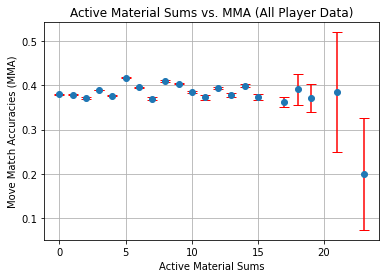

Correlation Coefficient:  0.6455242735675799
P Value:  0.23941629496065175


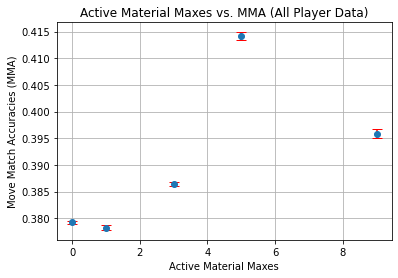

Correlation Coefficient:  -0.7379055378014192
P Value:  2.463771262370255e-08
[  1   2   0  -5  -1   3  -6  -3   7  -9  -2  -4   9   6  10   5   4  -7
   8 -10  -8 -11  12 -12 -14 -15  14  13  11  19 -17  17 -13  15  16  18
 -19 -16 -18  20  21 -23]


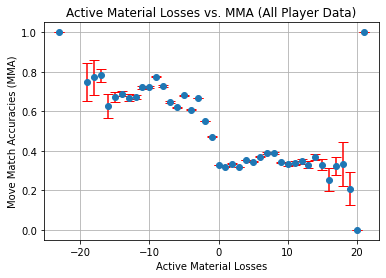

Correlation Coefficient:  -0.8741228872695928
P Value:  4.498632311308797e-06


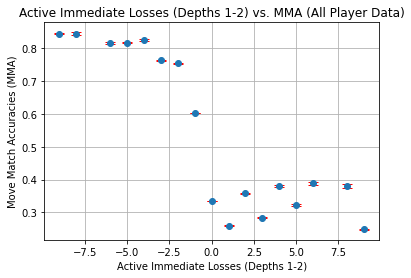

In [54]:
#------------------------plotting step---------------------------------

active_material_sums, accuracies_sums, standard_errors_sums, corr_co_sums, p_val_sums = active_material_sum(combined_delta_materials, combined_move_matches)
active_material_maxes, accuracies_maxes, standard_errors_maxes, corr_co_maxes, p_val_maxes = active_material_max(combined_delta_materials, combined_move_matches)
active_material_losses, accuracies_losses, standard_errors_losses, corr_co_losses, p_val_losses = active_material_loss(combined_delta_materials, combined_move_matches)

print("Correlation Coefficient: ", corr_co_sums)
print("P Value: ", p_val_sums)
plt.errorbar(active_material_sums, accuracies_sums, yerr=standard_errors_sums, fmt='o', capsize=5, ecolor='red')
# print(active_material_sums)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Material Sums')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Material Sums vs. MMA (All Player Data)')
plt.grid(True)
plt.show()

print("Correlation Coefficient: ", corr_co_maxes)
print("P Value: ", p_val_maxes)
plt.errorbar(active_material_maxes, accuracies_maxes, yerr=standard_errors_maxes, fmt='o', capsize=5, ecolor='red')
# print(active_material_maxes)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Material Maxes')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Material Maxes vs. MMA (All Player Data)')
plt.grid(True)
plt.show()

print("Correlation Coefficient: ", corr_co_losses)
print("P Value: ", p_val_losses)
plt.errorbar(active_material_losses, accuracies_losses, yerr=standard_errors_losses, fmt='o', capsize=5, ecolor='red')
print(active_material_losses)
# plt.xlim(-10, 10)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Material Losses')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Material Losses vs. MMA (All Player Data)')
plt.grid(True)
plt.show()


active_immediate_losses, accuracies_ail, standard_errors_ail, corr_co_ail, p_val_ail = active_immediate_loss_1(combined_delta_materials, combined_move_matches)
# print(active_immediate_losses)
print("Correlation Coefficient: ", corr_co_ail)
print("P Value: ", p_val_ail)
plt.errorbar(active_immediate_losses, accuracies_ail, yerr=standard_errors_ail, fmt='o', capsize=5, ecolor='red')
# plt.xlim(-10, 10)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Immediate Losses (Depths 1-2)')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Immediate Losses (Depths 1-2) vs. MMA (All Player Data)')
plt.grid(True)
plt.show()

In [55]:
# make this immediate loss plot for depths 3-4 (2nd move of each player) and depths 5-6 (3rd move of each player)
def active_immediate_loss_2(delta_materials, move_match):
    active_immediate_loss_hm = defaultdict(list)
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        immediate_loss = custom_immediate_val_2(active_player_delta) - custom_immediate_val_2(opponent_delta)
        if immediate_loss not in active_immediate_loss_hm:
            active_immediate_loss_hm[immediate_loss] = [0, 0]
            
        if move_match[i] == 1:
            active_immediate_loss_hm[immediate_loss][0] += 1
            active_immediate_loss_hm[immediate_loss][1] += 1
        else:
            active_immediate_loss_hm[immediate_loss][1] += 1
            
    active_immediate_losses, accuracies = [], []
    standard_errors = []
    for active_immediate_loss, [total_correct, total] in active_immediate_loss_hm.items():
        active_immediate_losses.append(active_immediate_loss)
        accuracies.append(total_correct / total)
        
        std_err = np.sqrt((accuracies[-1] * (1 - accuracies[-1])) / total)
        standard_errors.append(std_err)
        
    correlation_coefficient, p_val = pearsonr(active_immediate_losses, accuracies)
    return [np.array(active_immediate_losses), np.array(accuracies), np.array(standard_errors), correlation_coefficient, p_val]

def active_immediate_loss_3(delta_materials, move_match):
    active_immediate_loss_hm = defaultdict(list)
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        immediate_loss = custom_immediate_val_3(active_player_delta) - custom_immediate_val_3(opponent_delta)
        if immediate_loss not in active_immediate_loss_hm:
            active_immediate_loss_hm[immediate_loss] = [0, 0]
            
        if move_match[i] == 1:
            active_immediate_loss_hm[immediate_loss][0] += 1
            active_immediate_loss_hm[immediate_loss][1] += 1
        else:
            active_immediate_loss_hm[immediate_loss][1] += 1
            
    active_immediate_losses, accuracies = [], []
    standard_errors = []
    for active_immediate_loss, [total_correct, total] in active_immediate_loss_hm.items():
        active_immediate_losses.append(active_immediate_loss)
        accuracies.append(total_correct / total)
        
        std_err = np.sqrt((accuracies[-1] * (1 - accuracies[-1])) / total)
        standard_errors.append(std_err)
        
    correlation_coefficient, p_val = pearsonr(active_immediate_losses, accuracies)
    return [np.array(active_immediate_losses), np.array(accuracies), np.array(standard_errors), correlation_coefficient, p_val]

Correlation Coefficient:  -0.1713430736638429
P Value:  0.5108309518633687


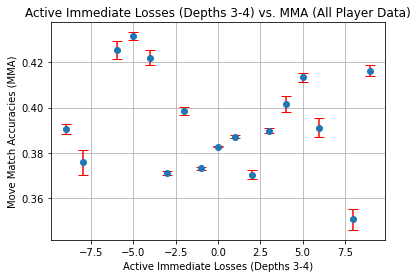

Correlation Coefficient:  0.2023158969822454
P Value:  0.4361349317073415


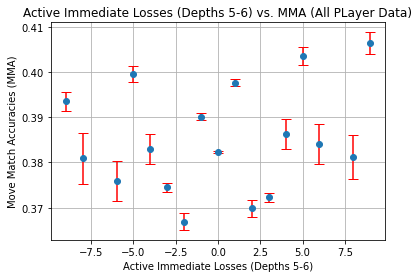

In [57]:
active_immediate_losses_2, accuracies_ail_2, standard_errors_ail_2, corr_co_ail_2, p_val_ail_2 = active_immediate_loss_2(combined_delta_materials, combined_move_matches)
# print(active_immediate_losses_2)
print("Correlation Coefficient: ", corr_co_ail_2)
print("P Value: ", p_val_ail_2)
plt.errorbar(active_immediate_losses_2, accuracies_ail_2, yerr=standard_errors_ail_2, fmt='o', capsize=5, ecolor='red')
# plt.xlim(-10, 10)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Immediate Losses (Depths 3-4)')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Immediate Losses (Depths 3-4) vs. MMA (All Player Data)')
plt.grid(True)
plt.show()

active_immediate_losses_3, accuracies_ail_3, standard_errors_ail_3, corr_co_ail_3, p_val_ail_3 = active_immediate_loss_3(combined_delta_materials, combined_move_matches)
# print(active_immediate_losses_3)
print("Correlation Coefficient: ", corr_co_ail_3)
print("P Value: ", p_val_ail_3)
plt.errorbar(active_immediate_losses_3, accuracies_ail_3, yerr=standard_errors_ail_3, fmt='o', capsize=5, ecolor='red')
# plt.xlim(-10, 10)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Immediate Losses (Depths 5-6)')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Immediate Losses (Depths 5-6) vs. MMA (All PLayer Data)')
plt.grid(True)
plt.show()